In [1]:
import os, getpass
from dotenv import load_dotenv
load_dotenv("../../.env")

True

In [2]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

class LapData(TypedDict):
    lap_number: int
    driver: str
    sector_times: List[float]
    tyre_compound: str
    incident_report: Optional[str]
    incident_penalty: Optional[str]

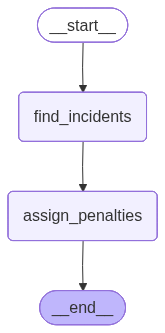

In [3]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class StewardState(TypedDict):
    parsed_lap_data: List[LapData]
    incidents: List[LapData]
    steward_report: str
    processed_laps: List[str]

class StewardOutputState(TypedDict):
    steward_report: str
    processed_laps: List[str]

def find_incidents(state):
    """Get laps that contain an incident report"""
    parsed_lap_data = state["parsed_lap_data"]
    incidents = [lap for lap in parsed_lap_data if lap.get("incident_report")]
    return {"incidents": incidents}

def assign_penalties(state):
    """Generate a steward report of penalties"""
    incidents = state["incidents"]
    report = "5-second penalty for VER (Lap 28, Track Limits)."
    return {"steward_report": report, "processed_laps": [f"steward-review-on-lap-{lap['lap_number']}" for lap in incidents]}

steward_builder = StateGraph(state_schema=StewardState, output_schema=StewardOutputState)
steward_builder.add_node("find_incidents", find_incidents)
steward_builder.add_node("assign_penalties", assign_penalties)
steward_builder.add_edge(START, "find_incidents")
steward_builder.add_edge("find_incidents", "assign_penalties")
steward_builder.add_edge("assign_penalties", END)

graph = steward_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

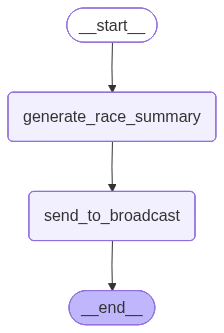

In [4]:
class CommentaryState(TypedDict):
    parsed_lap_data: List[LapData]
    race_summary: str
    tv_report: str
    processed_laps: List[str]

class CommentaryOutputState(TypedDict):
    tv_report: str
    processed_laps: List[str]

def generate_race_summary(state):
    """Generate a summary of race events"""
    parsed_lap_data = state["parsed_lap_data"]
    summary = "Great battle between HAM and LEC for P2!"
    return {"race_summary": summary, "processed_laps": [f"commentary-on-lap-{lap['lap_number']}" for lap in parsed_lap_data]}

def send_to_broadcast(state):
    """Format summary for TV broadcast"""
    race_summary = state["race_summary"]
    report = f"Broadcast: {race_summary}"
    return {"tv_report": report}

commentary_builder = StateGraph(CommentaryState, output_schema=CommentaryOutputState)
commentary_builder.add_node("generate_race_summary", generate_race_summary)
commentary_builder.add_node("send_to_broadcast", send_to_broadcast)
commentary_builder.add_edge(START, "generate_race_summary")
commentary_builder.add_edge("generate_race_summary", "send_to_broadcast")
commentary_builder.add_edge("send_to_broadcast", END)

graph = commentary_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
class RaceControlState(TypedDict):
    raw_lap_data: List[LapData]
    parsed_lap_data: List[LapData]
    steward_report: str
    tv_report: str
    processed_laps:  Annotated[List[str], add]

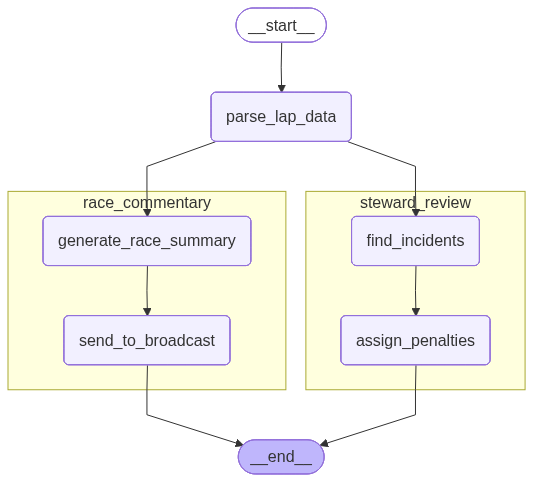

In [6]:
def parse_lap_data(state):
    """Clean and parse raw lap data"""
    raw_lap_data = state["raw_lap_data"]
    parsed_lap_data = raw_lap_data
    return {"parsed_lap_data": parsed_lap_data}

entry_builder = StateGraph(RaceControlState)
entry_builder.add_node("parse_lap_data", parse_lap_data)
entry_builder.add_node("steward_review", steward_builder.compile())
entry_builder.add_node("race_commentary", commentary_builder.compile())

entry_builder.add_edge(START, "parse_lap_data")
entry_builder.add_edge("parse_lap_data", "steward_review")
entry_builder.add_edge("parse_lap_data", "race_commentary")
entry_builder.add_edge("steward_review", END)
entry_builder.add_edge("race_commentary", END)

graph = entry_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
lap_27_data = LapData(
    lap_number=27,
    driver="HAM",
    sector_times=[22.1, 30.5, 25.3],
    tyre_compound="Medium"
)

lap_28_data = LapData(
    lap_number=28,
    driver="VER",
    sector_times=[21.9, 30.2, 25.1],
    tyre_compound="Hard",
    incident_report="Exceeded track limits at T4"
)

raw_logs = [lap_27_data, lap_28_data]
graph.invoke({"raw_lap_data": raw_logs})

{'raw_lap_data': [{'lap_number': 27,
   'driver': 'HAM',
   'sector_times': [22.1, 30.5, 25.3],
   'tyre_compound': 'Medium'},
  {'lap_number': 28,
   'driver': 'VER',
   'sector_times': [21.9, 30.2, 25.1],
   'tyre_compound': 'Hard',
   'incident_report': 'Exceeded track limits at T4'}],
 'parsed_lap_data': [{'lap_number': 27,
   'driver': 'HAM',
   'sector_times': [22.1, 30.5, 25.3],
   'tyre_compound': 'Medium'},
  {'lap_number': 28,
   'driver': 'VER',
   'sector_times': [21.9, 30.2, 25.1],
   'tyre_compound': 'Hard',
   'incident_report': 'Exceeded track limits at T4'}],
 'steward_report': '5-second penalty for VER (Lap 28, Track Limits).',
 'tv_report': 'Broadcast: Great battle between HAM and LEC for P2!',
 'processed_laps': ['commentary-on-lap-27',
  'commentary-on-lap-28',
  'steward-review-on-lap-28']}